In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import regularizers

import bayesflow as bf
from bayesflow.amortizers import AmortizedPointEstimator
from bayesflow.benchmarks import Benchmark
from bayesflow.simulation import GenerativeModel, Prior, Simulator
from bayesflow.summary_networks import DeepSet

2024-03-09 11:22:43.565567: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-09 11:22:43.594711: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-09 11:22:43.594778: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-09 11:22:43.595995: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-09 11:22:43.601839: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-09 11:22:43.602885: I tensorflow/core/platform/cpu_feature_guard.cc:1

# Likelihood-Free Parameter Estimation with Neural Bayes Estimators - BayesFlow edition

In this notebook, we will demonstrate how to learn amortized neural Bayes estimators, as decribed in the following [paper](https://www.tandfonline.com/doi/full/10.1080/00031305.2023.2249522):

    Sainsbury-Dale, M., Zammit-Mangion, A., & Huser, R. (2024).
    Likelihood-free parameter estimation with neural Bayes estimators.
    The American Statistician, 78(1), 1-14.

We will use BayesFlow's `AmortizedPointEstimator` class. There are two main differences to learning the full posterior distribution:

a) result: instead of samples from a distribution, we obtain one value per data set
b) network: instead of mapping from parameter space to latent space, with the (summarized) data as a condition, we directly map from the data to the parameter space

For a), we can leverage other means of uncertainty quantification, i.e. bootstrapping methods. For b), we just have to adapt the network input and output dimensions for the interference network accordingly. Here, we will use a simple MLP with residual connections in the hidden block:

In [2]:
class ConfigurableHiddenBlock(tf.keras.Model):
    def __init__(
        self, num_units, activation="relu", residual_connection=True, dropout_rate=0.0, kernel_regularization=0.0
    ):
        super().__init__()

        self.act_func = tf.keras.activations.get(activation)
        self.residual_connection = residual_connection
        self.dense = tf.keras.layers.Dense(
            num_units, activation=None, kernel_regularizer=regularizers.l2(kernel_regularization)
        )
        self.dropout_rate = dropout_rate

    @tf.function
    def call(self, inputs, training=False, mask=None):
        x = self.dense(inputs)
        x = tf.nn.dropout(x, self.dropout_rate)

        if self.residual_connection:
            x += inputs
        return self.act_func(x)


class ConfigurableMLP(tf.keras.Model):
    """Implements a configurable MLP with optional residual connections and dropout."""

    def __init__(
        self,
        input_dim,
        output_dim,
        hidden_dim=512,
        num_hidden=2,
        activation="relu",
        residual_connections=True,
        dropout_rate=0.0,
        kernel_regularization=0.0,
    ):
        """
        Creates an instance of a flexible MLP with optional residual connections
        and dropout.

        Parameters:
        -----------
        input_dim : int
            The input dimensionality
        output_dim : int
            The output dimensionality
        hidden_dim: int, optional, default: 512
            The dimensionality of the hidden layers
        num_hidden: int, optional, default: 2
            The number of hidden layers (minimum 1)
        activation: string, optional, default: 'relu'
            The activation function of the dense layers
        residual_connections: bool, optional, default: True
            Use residual connections in the MLP
        dropout_rate        : float, optional, default: 0.0
            Dropout rate for the hidden layers in the MLP
        kernel_regularization: float, optional, default: 0.0
            L2 regularization factor for the kernel weights
        """
        super().__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim

        self.model = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(
                    hidden_dim, activation=activation, kernel_regularizer=regularizers.l2(kernel_regularization)
                ),
            ]
        )
        for _ in range(num_hidden):
            self.model.add(
                ConfigurableHiddenBlock(
                    hidden_dim,
                    activation=activation,
                    residual_connection=residual_connections,
                    dropout_rate=dropout_rate,
                    kernel_regularization=kernel_regularization,
                )
            )
        self.model.add(tf.keras.layers.Dense(output_dim))

    @tf.function
    def call(self, inputs, training=False, mask=None):
        return self.model(tf.concat(inputs, axis=-1), training=training)

## Simple Benchmark from the BayesFlow Benchmark Suite: Gaussian Linear

To get familiar with the API, we start with a simple toy example with a 10-dimensional Gaussian likelihood. We use multiple observations `"n_obs"` and summarize them using a standard `DeepSet`, which outputs `summary_dim` values. The loss function can be configured in two ways. If `loss_fun` is passed, the supplied function serves as the loss. As a shorthand, if `norm_ord` is passed, the `tf.norm` function is used and `norm_ord` is passed as its `ord` argument.

In [3]:
benchmark = Benchmark("gaussian_linear", mode="posterior", sim_kwargs={"n_obs": 10})

# Summary network to jointly learn summary statistics
summary_dim = 20
summary_net = DeepSet(summary_dim)

# An easy-to-use MLP with residual connections
inference_net = ConfigurableMLP(input_dim=summary_dim, output_dim=10, dropout_rate=0.05)

# Can be any norm in [1, 2, np.inf] and can also use a summary network
amortizer = AmortizedPointEstimator(inference_net, summary_net=summary_net, norm_ord=2)

INFO:root:Performing 2 pilot runs with the gaussian_linear model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 10)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 10, 10)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


Next, we have to provide a configurator, to assure that the data is first passed to the _summary network_, and not directly to the inference network

In [4]:
def config(forward_dict):
    """Helper function for posterior configuration."""

    input_dict = {}
    input_dict["parameters"] = forward_dict["prior_draws"].astype(np.float32)
    # we use "summary_conditions" and not "direct_conditions" to pass the data
    # to the summary network
    input_dict["summary_conditions"] = forward_dict["sim_data"].astype(np.float32)
    return input_dict

Training can happen as usual. Here we use offline training, but online training can be used as well (see the next section for an example).

In [5]:
# Training can happen as usual
trainer = bf.trainers.Trainer(amortizer=amortizer, configurator=config)
data = benchmark.generative_model(5000)

INFO:root:Trainer initialization: No generative model provided. Only offline learning mode is available!


In [6]:
h = trainer.train_offline(data, epochs=10, batch_size=32)

Training epoch 10: 100%|██████████| 157/157 [00:00<00:00, 162.07it/s, Epoch: 10, Batch: 157,Loss: 0.106,W.Decay: 0.000,Avg.Loss: 0.109,Avg.W.Decay: 0.000,LR: 5.07E-10]


Finally, we can make a quick visual sanity check by plotting the estimates agains the true parameters:

In [7]:
# Quick point estimates can be obtained by simply calling the .estimate() method
test_data = config(benchmark.generative_model(100))

In [8]:
estimates = amortizer.estimate(test_data)

In [9]:
true_params = test_data["parameters"]

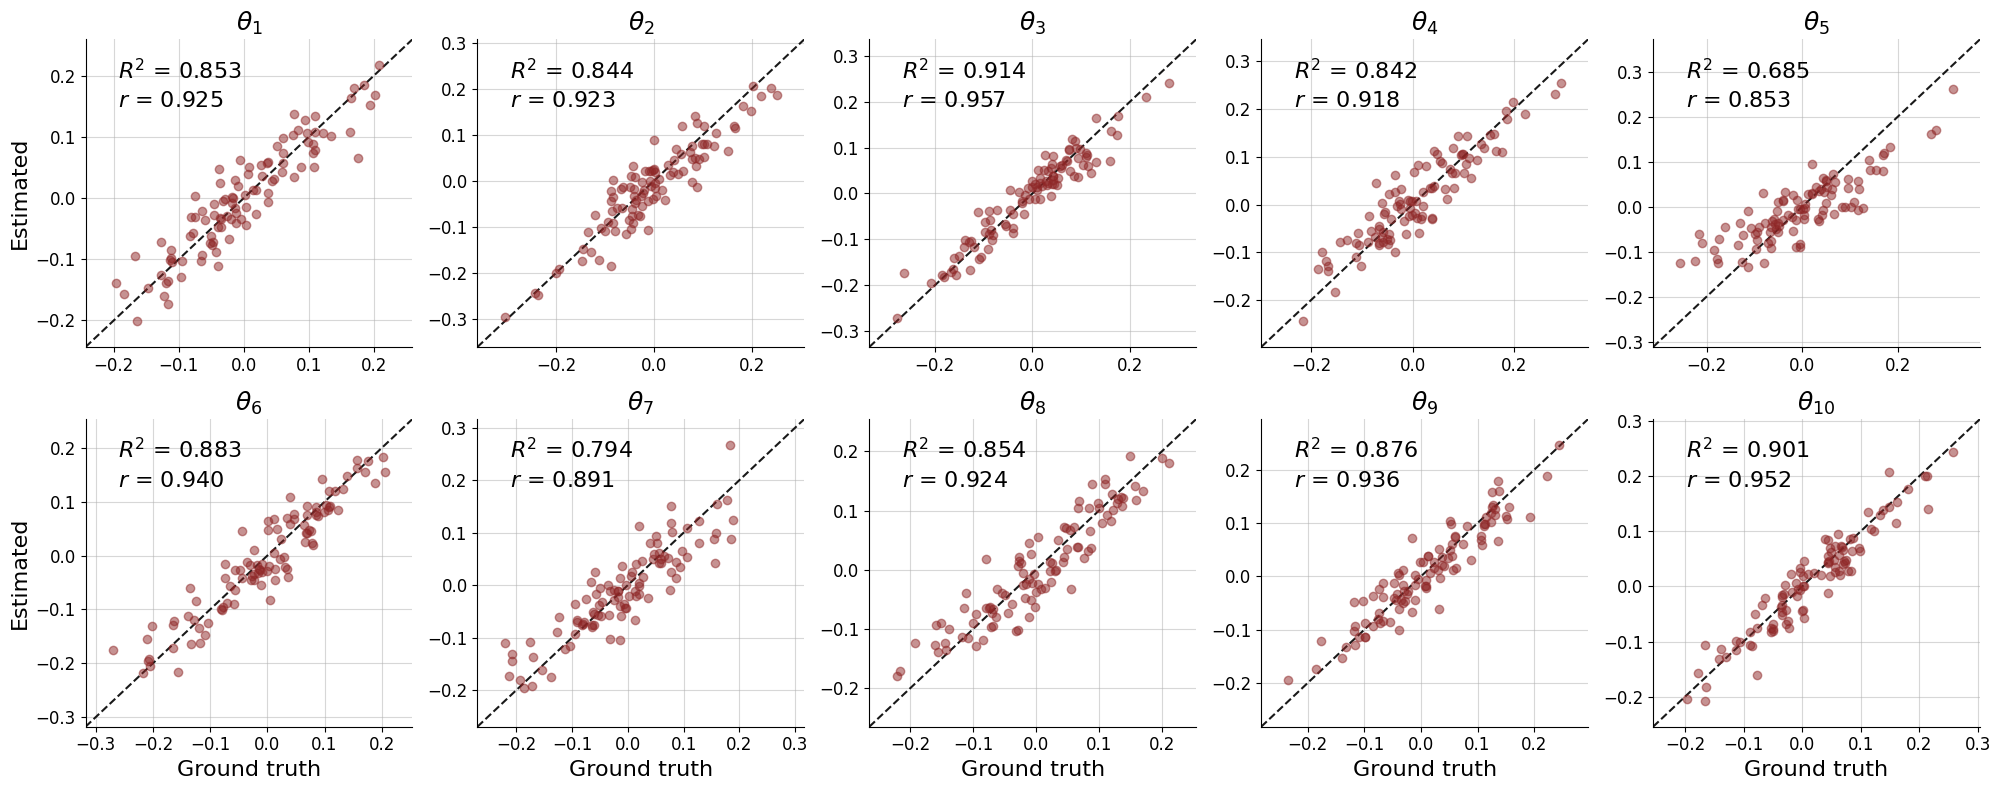

In [10]:
fig = bf.diagnostics.plot_recovery(
    estimates[:, None], true_params, uncertainty_agg=lambda x, *args, **kwargs: tf.zeros_like(x)[:, 0]
)

We can see that the recovery looks sensible, the network seems to have captured at least some information from the data. Try to vary `n_obs` and observe how the correlations change.

## Illustrative Example from the Paper

In section 2.2.3 of the paper, a simple one-dimensional example is given as a demonstration and sanity check. Here, we want to replicate the main result, namely that the learned amortized Bayes estimator closely resembles the analytical one. Please refer to the paper for background and formulas.

First, we specify out generative model. The prior is a Pareto distribution with $\alpha=4$ and $\beta=1$. The likelihood is a uniform distribution, with a minimum value of zero and a maximum value which is determined by the parameter $\theta$. For efficiency, we create a _batched_ simulator, i.e. we generate a whole batch of data in one function call.

In [11]:
def batch_prior_fun(batch_size):
    dist = tfp.distributions.Pareto(4.0, 1.0)
    return dist.sample((batch_size, 1))


def batch_simulator_fun(theta, n_obs=10):
    return tf.random.uniform((theta.shape[0], 10), maxval=theta)[:, :, None]


prior = Prior(batch_prior_fun=batch_prior_fun)
simulator = Simulator(batch_simulator_fun=batch_simulator_fun)
generative_model = GenerativeModel(prior=prior, simulator=simulator)

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 1)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 10, 1)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


Again, we specify a summary network. As the dimensionality is lower (1) this time, a smaller number of summary dimensions should be sufficient. We use `norm_ord=1`, i.e. an absolute-error loss, to obtain the posterior median, as required in this example.

In [12]:
summary_dim = 5
summary_net = DeepSet(summary_dim)

inference_net = ConfigurableMLP(input_dim=summary_dim, output_dim=1, dropout_rate=0.00)

amortizer = AmortizedPointEstimator(inference_net, summary_net=summary_net, norm_ord=1)

The configurator is similar to the one above, but we skip the `.astype` calls, as the generative model already produces TensorFlow tensors.

In [13]:
def config(forward_dict):
    """Helper function for posterior configuration."""

    input_dict = {}
    input_dict["parameters"] = forward_dict["prior_draws"]
    # we use "summary_conditions" and not "direct_conditions" to pass the data
    # to the summary network
    input_dict["summary_conditions"] = forward_dict["sim_data"]
    return input_dict

This time, we supply the generative model to the `Trainer`, which enables _online_ training.

In [14]:
trainer = bf.trainers.Trainer(amortizer=amortizer, configurator=config, generative_model=generative_model)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [15]:
%%time
h = trainer.train_online(50, 200, batch_size=32)

Training epoch 50: 100%|██████████| 200/200 [00:01<00:00, 108.76it/s, Epoch: 50, Iter: 200,Loss: 0.080,W.Decay: 0.000,Avg.Loss: 0.071,Avg.W.Decay: 0.000,LR: 1.49E-11]

CPU times: user 4min 22s, sys: 19 s, total: 4min 41s
Wall time: 1min 35s


To test the estimator, we generate data with a fixed parameter $\theta=4/3$. To keep the code as simple as possible, we just modify the prior of the simulated model to only return the desired theta:

In [16]:
# Quick point estimates can be obtained by simply calling the .estimate() method
num_test = 30_000
test_param_fun = lambda batch_size: tf.ones((batch_size, 1)) * 4 / 3  # set theta to 4/3 for all simulations
test_model = GenerativeModel(prior=Prior(batch_prior_fun=test_param_fun), simulator=simulator)
test_data = config(test_model(num_test))

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 1)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 10, 1)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


Using the amortizers `estimate` method, we can obtain the estimate for each data set.

In [17]:
%%time
estimates = amortizer.estimate(test_data)[:, 0]

CPU times: user 3.47 s, sys: 3.96 s, total: 7.43 s
Wall time: 907 ms


For comparison, we calculate the values with the analytic Bayes estimator as well:

In [18]:
def bayes_estimator(Z, alpha=4, beta=1):
    m = Z.shape[-2]
    max_vals = np.max(Z, axis=-2)
    return np.power(2, 1 / (alpha + m)) * np.maximum(max_vals, beta)


reference = bayes_estimator(test_data["summary_conditions"])[:, 0]

Finally, we compare both the kernel density estimate of the estimators distribution and the correlation between analytical and estimated values:

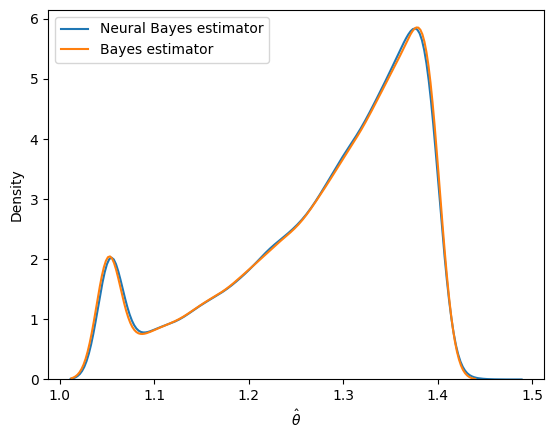

In [26]:
sns.kdeplot(estimates, label="Neural Bayes estimator")
sns.kdeplot(reference, label="Bayes estimator")
plt.xlabel(r"$\hat\theta$")
_ = plt.legend()

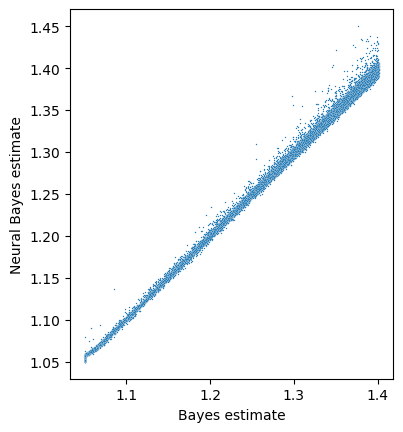

In [41]:
sns.scatterplot(x=reference, y=estimates, s=1)
plt.gca().set_aspect("equal")
plt.xlabel("Bayes estimate")
_ = plt.ylabel("Neural Bayes estimate")